# Восстановление золота из руды

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.  
  
**Технологический процесс**  
Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку:  
1. Флотация  
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).  
2. Очистка   
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.  
  
**Описание данных**  
**Технологический процесс**  
`Rougher feed` — исходное сырье  
`Rougher additions` (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant  
`Xanthate` — ксантогенат (промотер, или активатор флотации);  
`Sulphate` — сульфат (на данном производстве сульфид натрия);  
`Depressant` — депрессант (силикат натрия).  
`Rougher process` (англ. «грубый процесс») — флотация  
`Rougher tails` — отвальные хвосты  
`Float banks` — флотационная установка  
`Cleaner process` — очистка  
`Rougher Au` — черновой концентрат золота  
`Final Au` — финальный концентрат золота  
  
**Параметры этапов**  
`air amount` — объём воздуха  
`fluid levels` — уровень жидкости  
`feed size` — размер гранул сырья  
`feed rate` — скорость подачи  

**Наименование признаков**  
[этап].[тип_параметра].[название_параметра]  
Пример: `rougher.input.feed_ag`  
  
**Возможные значения для блока [этап]:**    
`rougher` — флотация  
`primary_cleaner` — первичная очистка  
`secondary_cleaner` — вторичная очистка  
`final` — финальные характеристики  

**Возможные значения для блока [тип_параметра]:**  
`input` — параметры сырья  
`output` — параметры продукта  
`state` — параметры, характеризующие текущее состояние этапа  
`calculation` — расчётные характеристик  

Импортируем пакеты

In [145]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

In [146]:
pd.options.display.max_rows = 30

## 1 Подготовка данных

### 1.1 Загрузка файлов и проверка данных

In [147]:
BASE_DIR = os.getcwd()
train = pd.read_csv(f'{BASE_DIR}/datasets/gold_recovery_train_new.csv')
test = pd.read_csv(f'{BASE_DIR}/datasets/gold_recovery_test_new.csv')
full = pd.read_csv(f'{BASE_DIR}/datasets/gold_recovery_full_new.csv')

In [148]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [149]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [150]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


- часть признаков отсутствует в тестовой выборке;  
- в данных есть пропуски;  
- столбец `date` можно удалить;   
- можно попробовать изменить тип данных на более лёгкий.

### 1.2 Проверка корректности рассчёта MAE

Порверим, что эффективность обогащения рассчитана правильно. Формула для вычисления recovery:

${\large Recovery=\dfrac{C(F-T)}{F(C-T)}\times 100\%}$  
где:  
C — доля золота в концентрате после флотации/очистки;  
F — доля золота в сырье/концентрате до флотации/очистки;  
T — доля золота в отвальных хвостах после флотации/очистки.

In [151]:
def recovery(c, f, t):
    return ((c*(f-t))/(f*(c-t)))*100

Для обучающей выборки для рассчёта `recovery` используем следующие признаки:

C = rougher.output.concentrate_au  
F = rougher.input.feed_au  
T = rougher.output.tail_au  

In [152]:
c_t = train['rougher.output.concentrate_au']
f_t = train['rougher.input.feed_au']
t_t = train['rougher.output.tail_au']
train_rougher_output_recovery_calc = recovery(c_t, f_t, t_t)
train_rougher_output_recovery_calc

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Length: 14149, dtype: float64

In [153]:
train['rougher.output.recovery']

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Name: rougher.output.recovery, Length: 14149, dtype: float64

На первый взгляд рассчётные значения целевого признака совпадают со значениями в исходных данных, оценим MAE по этим признакам

In [154]:
mae(train['rougher.output.recovery'], train_rougher_output_recovery_calc)


9.73512347450521e-15

MAE близок к 0, следовательно, данные признака rougher.output.recovery рассчитаны верно

### 1.3. Проанализируем признаки, которые отсутствуют в тестовой выборке.

In [155]:
columns_to_drop = (set(train.columns) - set(test.columns))
columns_to_drop

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Признаки, которые доступны в полной выборке, но недоступны в тестовой:  
calculation - рассчётный признаки;  
output      - признаки на выходе каждого из этапов производства.   

Нас не интересуют признаки отсутствующие в тестовой выборке, мы можем удалить их и из обучающей выборки на следующем этапе, кроме целевых признаков `rougher.output.recovery` и `final.output.recovery`

In [156]:
columns_to_drop.remove('rougher.output.recovery')
columns_to_drop.remove('final.output.recovery')

In [157]:
columns_to_drop

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'secondary_cleane

### 1.4. Предобработка данных.

Предобработку проводим только для обучающей и тестовой выборок, выборку содержащую все данные мы использовать не будем.

#### 1.4.1 Удаление признаков из обучающей выборки

Удалим признаки из категорий `calculation` и `output`

In [158]:
train = train.drop(columns_to_drop, axis=1)

#### 1.4.2 Добавление целевых признаков в тестовую выборку

В тестовой выборке отсутствуют целевые признаки, мы можем добавить их из полной выборки.

In [159]:
test['date'].duplicated().sum()

0

В столбце `date` отсутствуют дубликаты, мы можем использовать его в качестве индекса при слиянии датафреймов не опасаясь дублирования и потери объектов.

In [160]:
test = test.merge(full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='left')
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

#### 1.4.3 Матрица корреляции

In [161]:
len(train.columns)

55

Даже после удаления части признаков стоит проверить действительно ли все они необходимы, в случае обнаружения мультиколинеарности мы сможем удалить ещё часть признаков, что в дальнейшем улучшит результат обучения модели и сократит время рассчётов.

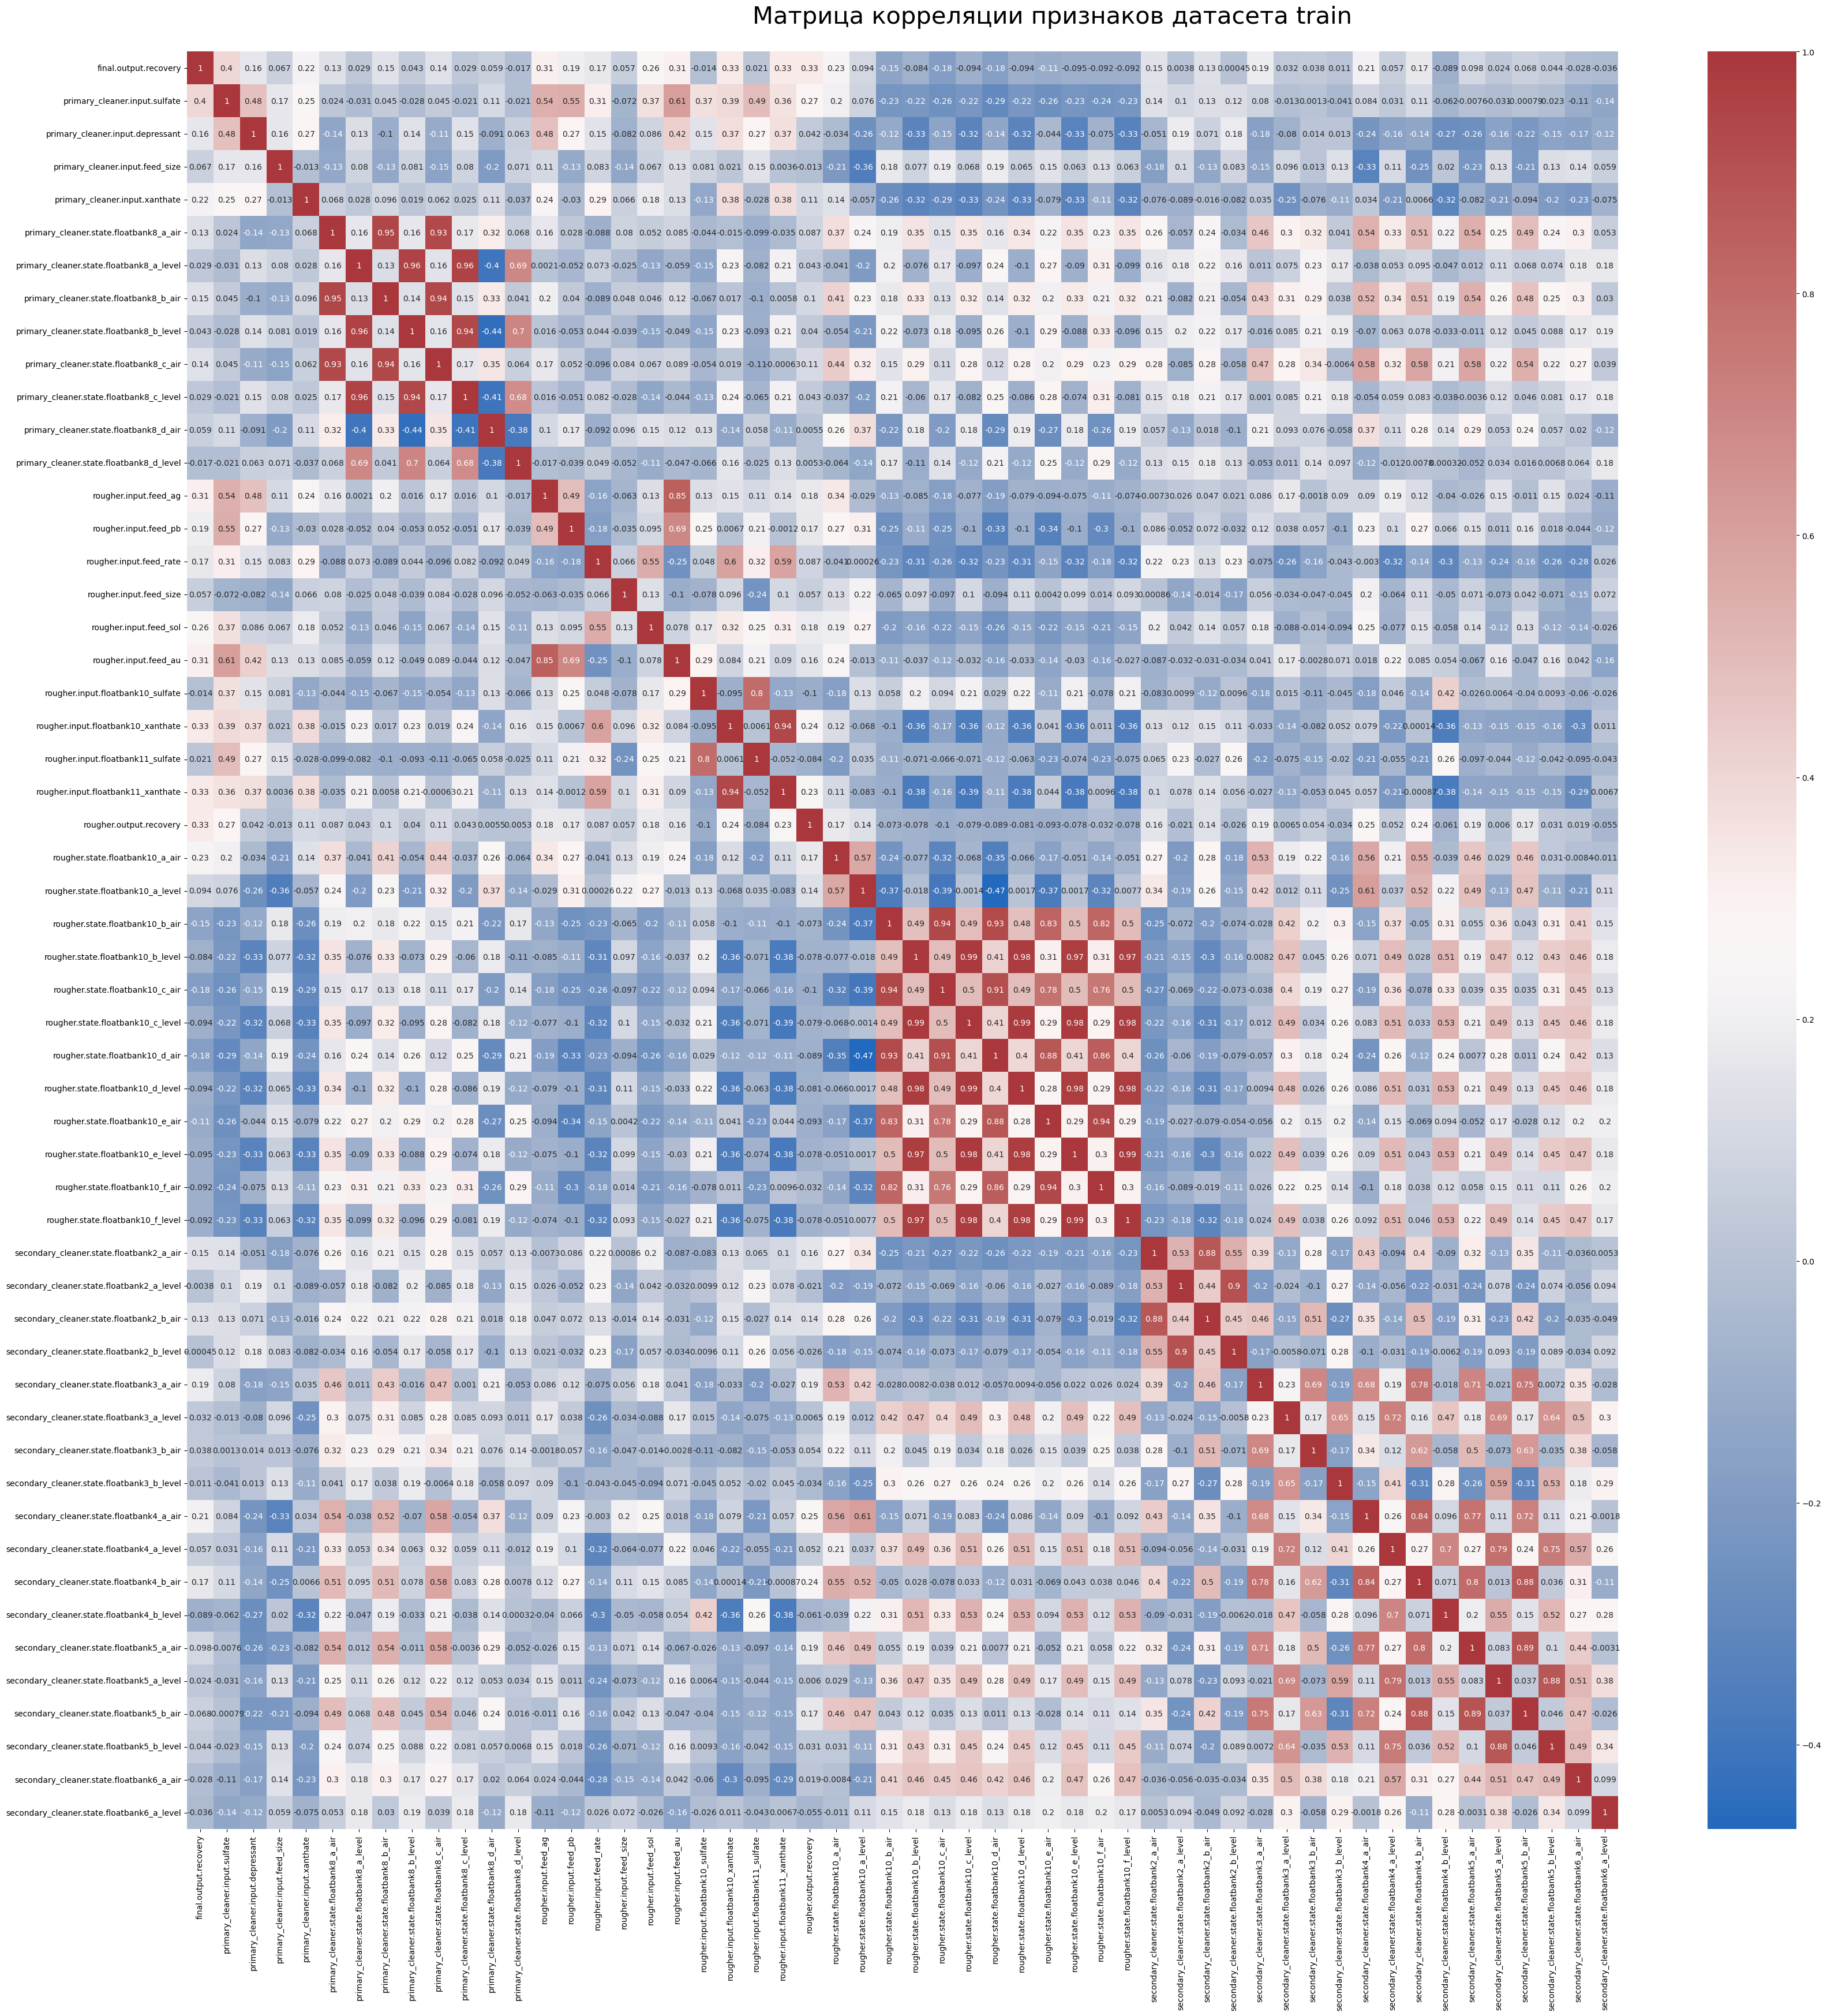

In [162]:
# рассчитываем попарные значения корреляции между признаками
corr = train.corr()

# вывод матрицы
fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(corr, annot=True, cmap='vlag', ax=ax)
fig.suptitle("Матрица корреляции признаков датасета train", fontsize=30, y=0.9)
plt.show()

Отфильтруем признаки по коэффициенту корелляции, лучшие значения модели были получены при пороге 0.95

In [163]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

# удаляем признаки
train = train.drop(train[to_drop], axis=1)

In [164]:
# удалим те же признаки для тестовой выборки
test = test.drop(test[to_drop], axis=1)

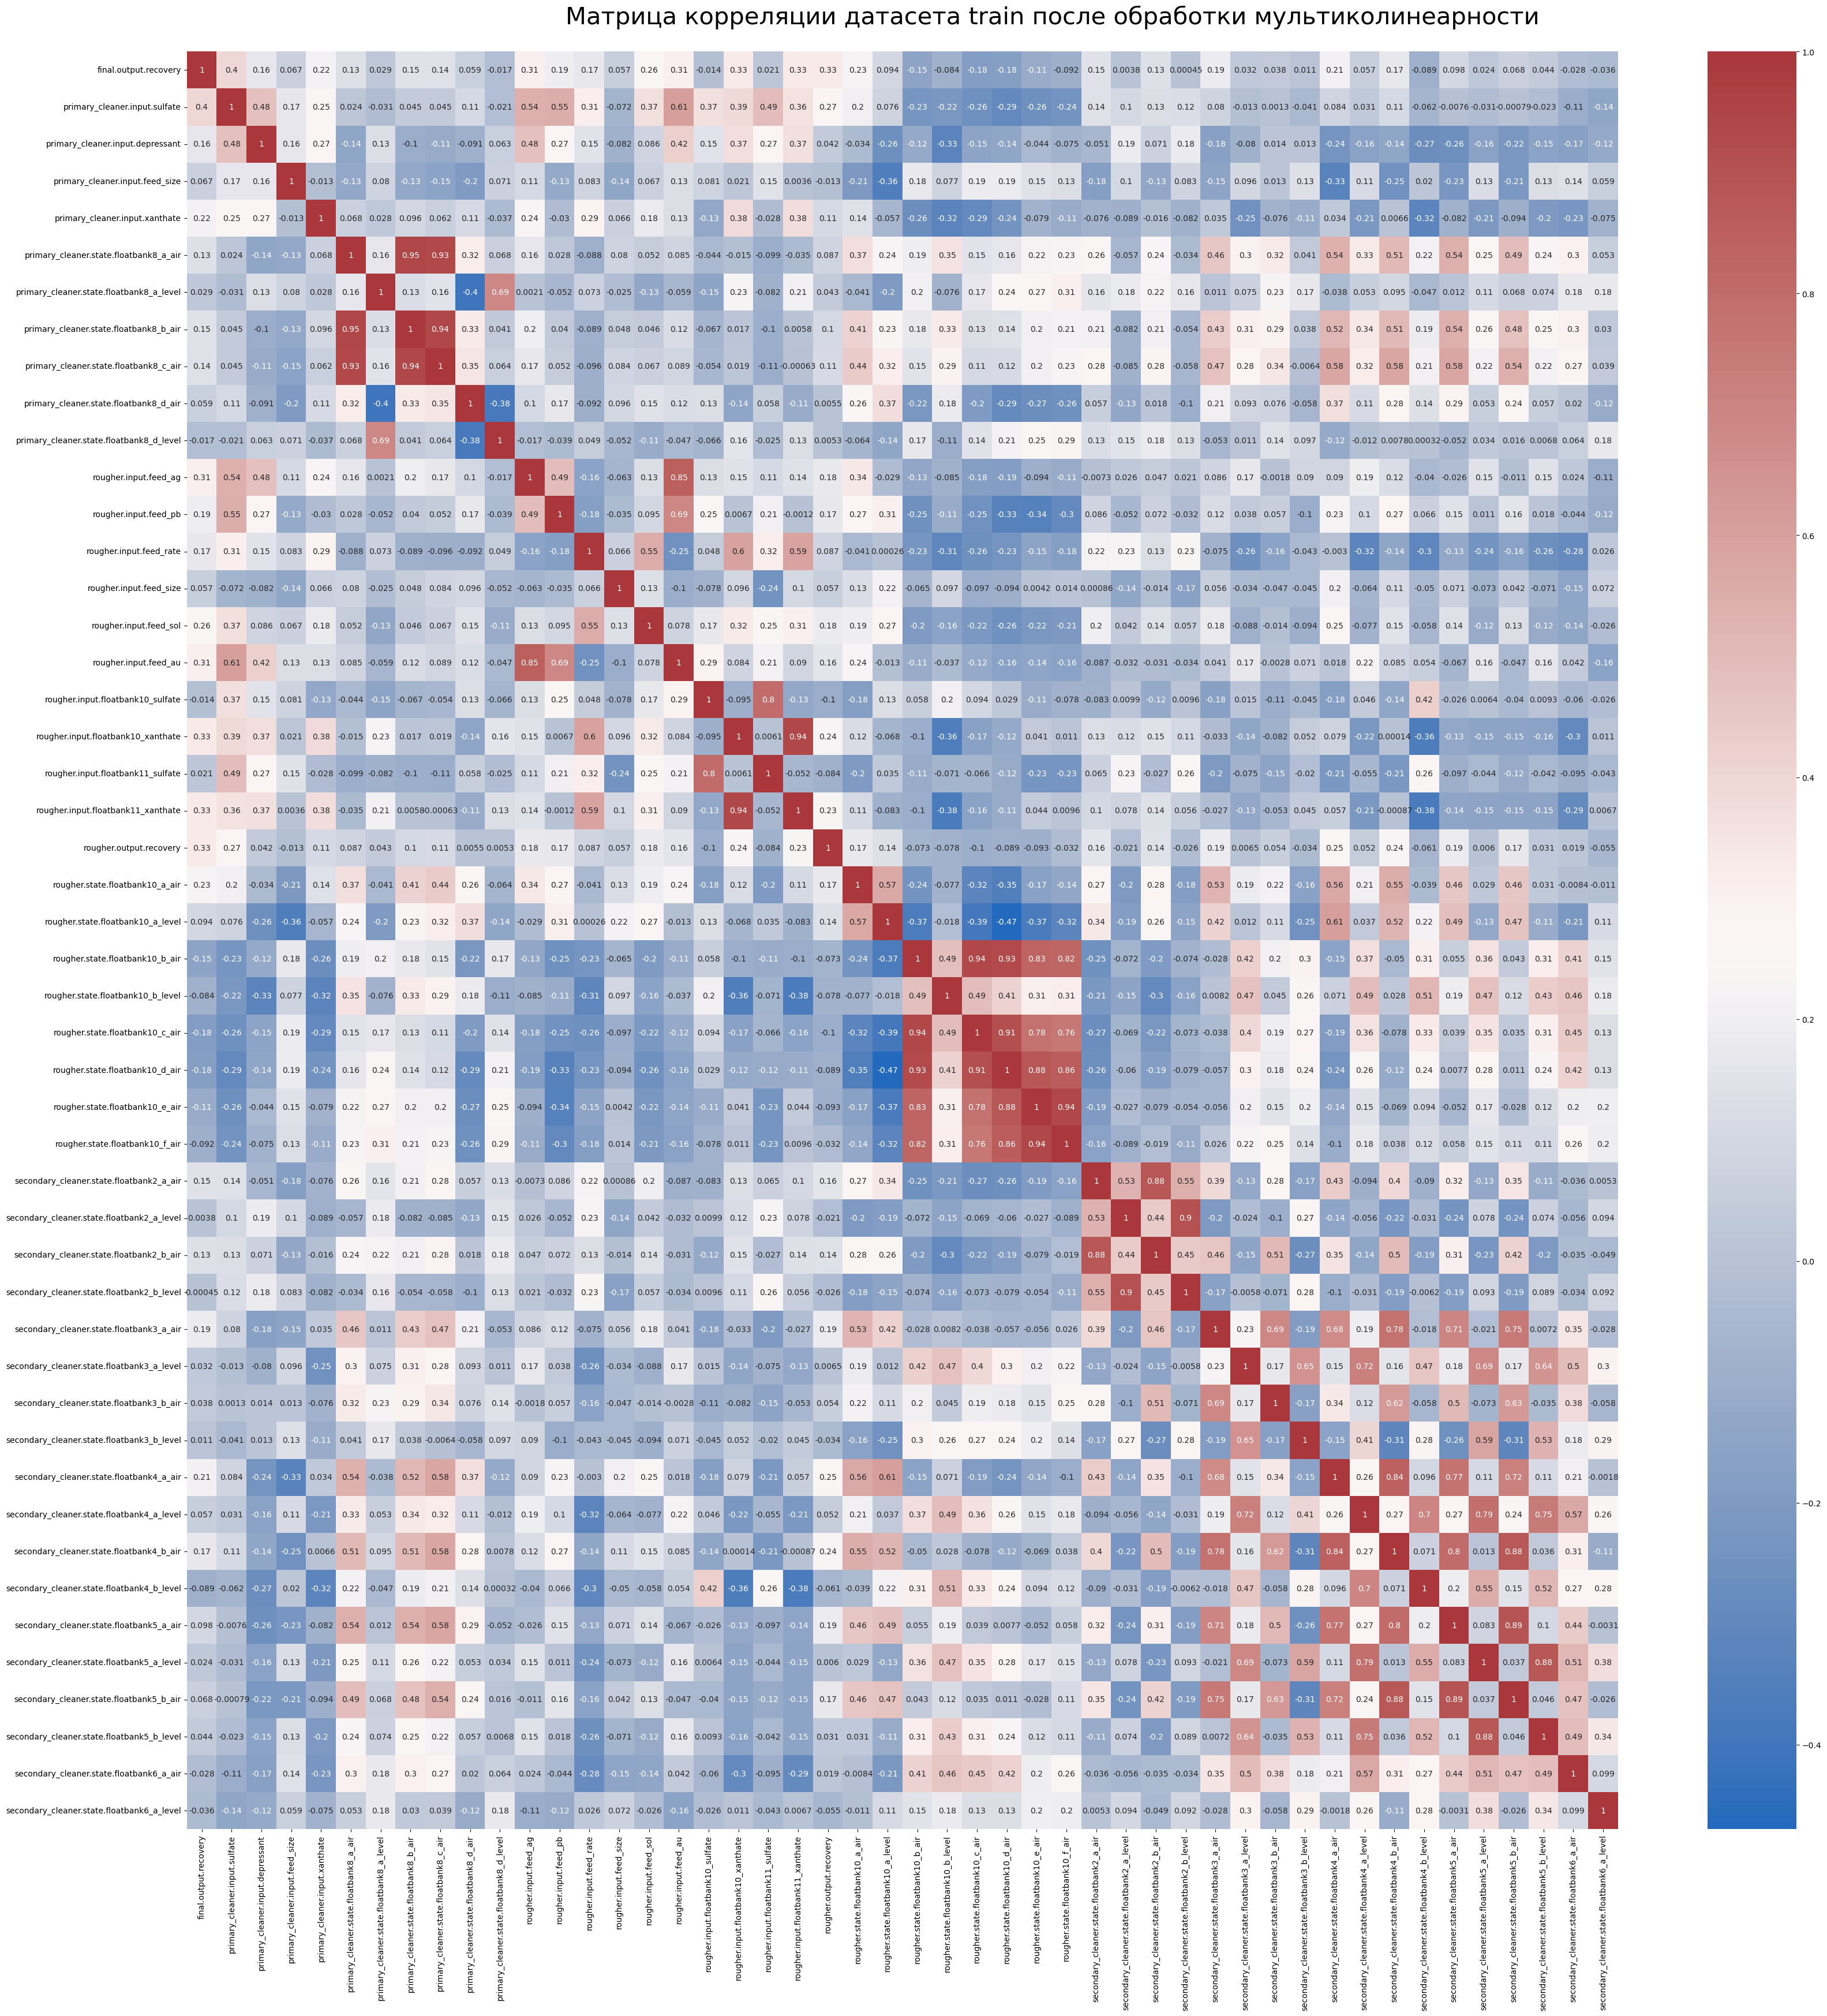

In [165]:
# проверим результат удаления признаков
corr = train.corr()

fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(corr, annot=True, cmap='vlag', ax=ax)
fig.suptitle(
    "Матрица корреляции датасета train после обработки мультиколинеарности", fontsize=30, y=0.9)
plt.show()

#### 1.4.4 Поиск дубликатов

In [166]:
train.duplicated().sum()

0

In [167]:
test.duplicated().sum()

0

Дублиактов в данных не обнаружено

#### 1.4.5 Заполнение пропусков

Проверим пропуски в тестовой выборке.

In [168]:
test.shape

(5290, 49)

In [169]:
pd.options.display.max_rows = None
test.isna().sum()

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatbank10_xanthate             0
rougher.input.floatbank11_sulfate              8
rougher.input.floatb

В тестовой выборке доля пропусков незначительна, мы можем просто удалить эти объекты.

In [170]:
test.dropna(inplace=True)

In [171]:
test.isna().sum().sum()

0

Проверим пропуски в обучающей выборке.

In [172]:
train.shape

(14149, 49)

In [173]:
train.isna().sum()

date                                            0
final.output.recovery                           0
primary_cleaner.input.sulfate                  20
primary_cleaner.input.depressant               32
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                100
primary_cleaner.state.floatbank8_a_air          4
primary_cleaner.state.floatbank8_a_level        1
primary_cleaner.state.floatbank8_b_air          4
primary_cleaner.state.floatbank8_c_air          2
primary_cleaner.state.floatbank8_d_air          3
primary_cleaner.state.floatbank8_d_level        1
rougher.input.feed_ag                           0
rougher.input.feed_pb                         100
rougher.input.feed_rate                         8
rougher.input.feed_size                       144
rougher.input.feed_sol                         78
rougher.input.feed_au                           0
rougher.input.floatbank10_sulfate              29
rougher.input.floatbank10_xanthate              8


In [174]:
pd.options.display.max_rows = 30

In [175]:
train_na_top = train.isna().sum().sort_values(ascending=False).head(15)
train_na_top

rougher.state.floatbank10_e_air             436
rougher.input.floatbank11_xanthate          428
secondary_cleaner.state.floatbank2_a_air    217
rougher.input.feed_size                     144
rougher.input.feed_pb                       100
primary_cleaner.input.xanthate              100
rougher.input.feed_sol                       78
rougher.input.floatbank11_sulfate            36
primary_cleaner.input.depressant             32
rougher.input.floatbank10_sulfate            29
secondary_cleaner.state.floatbank2_b_air     21
primary_cleaner.input.sulfate                20
rougher.input.floatbank10_xanthate            8
rougher.input.feed_rate                       8
secondary_cleaner.state.floatbank4_a_air      6
dtype: int64

Проверим все ли признаки нам действительно понадобятся, сможем ли мы заполнить пропуски хотя бы по признакам с самым большим числом пропусков

Были проверены несколько способов обработки пропусков, далее они расположены  порядке возрастания их эфективности при проверке на тестовой выборке:  
ffill,   
интерполяция,   
заполнение по средней скользящей,  
заполнение средним,  
удаление пропусков.  
  
Самым эфективным методом оказалось удаление пропусков   

In [176]:
train.dropna(inplace=True)
train.isna().sum().sum()

0

In [177]:
# train['rougher.state.floatbank10_e_air'] = train['rougher.state.floatbank10_e_air'].fillna(train['rougher.state.floatbank10_e_air'].mean())
# train['rougher.input.floatbank11_xanthate'] = train['rougher.input.floatbank11_xanthate'].fillna(train['rougher.input.floatbank11_xanthate'].mean())
# train['secondary_cleaner.state.floatbank2_a_air'] = train['secondary_cleaner.state.floatbank2_a_air'].fillna(train['secondary_cleaner.state.floatbank2_a_air'].mean())
# train['rougher.input.feed_size'] = train['rougher.input.feed_size'].fillna(train['rougher.input.feed_size'].mean())
# train['rougher.input.feed_pb'] = train['rougher.input.feed_pb'].fillna(train['rougher.input.feed_pb'].mean())
# train.dropna(inplace=True)
# train.isna().sum().sum()


In [178]:
# train['rougher.state.floatbank10_e_air'] = train['rougher.state.floatbank10_e_air'].rolling(100,center=True,min_periods=1).mean()
# train['rougher.input.floatbank11_xanthate'] = train['rougher.input.floatbank11_xanthate'].rolling(100,center=True,min_periods=1).mean()
# train['secondary_cleaner.state.floatbank2_a_air'] = train['secondary_cleaner.state.floatbank2_a_air'].rolling(100,center=True,min_periods=1).mean()
# train['rougher.input.feed_size'] = train['rougher.input.feed_size'].rolling(100,center=True,min_periods=1).mean()
# train['rougher.input.feed_pb'] = train['rougher.input.feed_pb'].rolling(100,center=True,min_periods=1).mean()
# train.dropna(inplace=True)
# train.isna().sum().sum()


In [179]:
# train['rougher.state.floatbank10_e_air'] = train['rougher.state.floatbank10_e_air'].interpolate()
# train['rougher.input.floatbank11_xanthate'] = train['rougher.input.floatbank11_xanthate'].interpolate()
# train['secondary_cleaner.state.floatbank2_a_air'] = train['secondary_cleaner.state.floatbank2_a_air'].interpolate()
# train['rougher.input.feed_size'] = train['rougher.input.feed_size'].interpolate()
# train['rougher.input.feed_pb'] = train['rougher.input.feed_pb'].interpolate()
# train.dropna(inplace=True)
# train.isna().sum().sum()


In [180]:
# train['rougher.state.floatbank10_e_air'] = train['rougher.state.floatbank10_e_air'].ffill()
# train['rougher.input.floatbank11_xanthate'] = train['rougher.input.floatbank11_xanthate'].ffill()
# train['secondary_cleaner.state.floatbank2_a_air'] = train['secondary_cleaner.state.floatbank2_a_air'].ffill()
# train['rougher.input.feed_size'] = train['rougher.input.feed_size'].ffill()
# train['rougher.input.feed_pb'] = train['rougher.input.feed_pb'].ffill()
# train.dropna(inplace=True)
# train.isna().sum().sum()


In [181]:
# train['rougher.input.floatbank11_xanthate'].plot(kind='line', color='red', alpha=1, figsize=[40, 10])
# train['rougher.input.floatbank11_xanthate'] = pd.to_numeric(train['rougher.input.floatbank11_xanthate'], errors="coerce").interpolate()
# train['rougher.input.floatbank11_xanthate'].plot(kind='line', color='blue',  alpha=0.6, figsize=[40, 10], secondary_y=True)

# plt.legend(loc='upper left')
# plt.show()


Удалим объекты с пропусками.

In [182]:
train.shape

(12679, 49)

#### 1.4.6 Анализ распределений признаков на предмет выбросов.

В поиске аномалий попробуем пройтись циклом по признакам в обучающей выборке

In [183]:
features_list = [i for i in train.columns if (('output' in i) or ('input' in i) or ('concentrate' in i))]

In [184]:
features_list

['final.output.recovery',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.output.recovery']

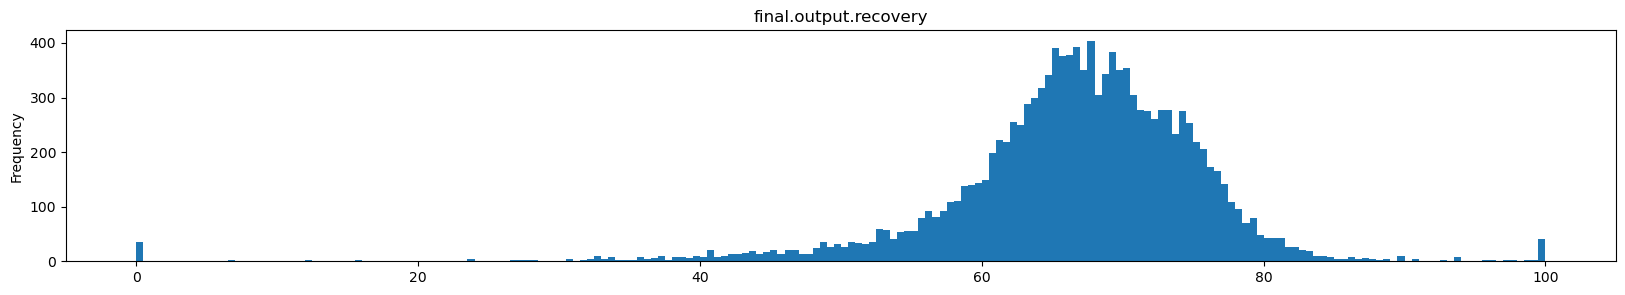

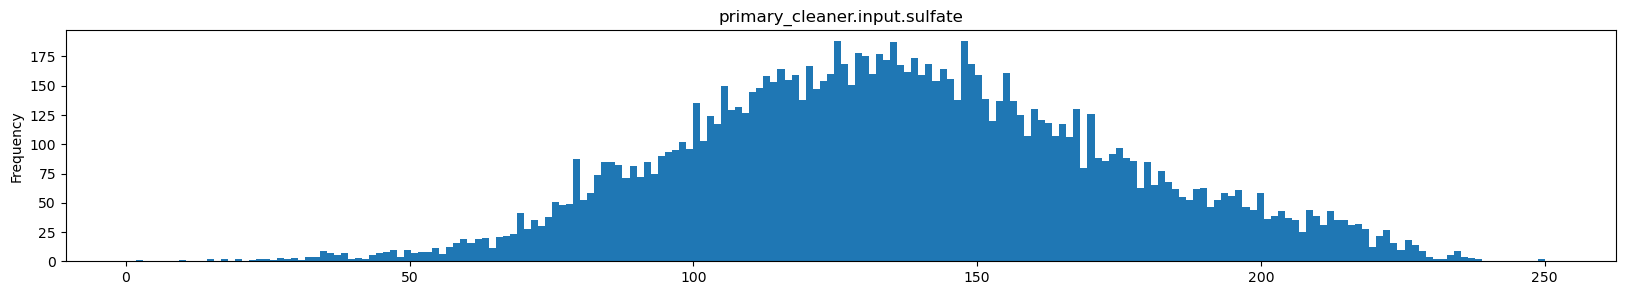

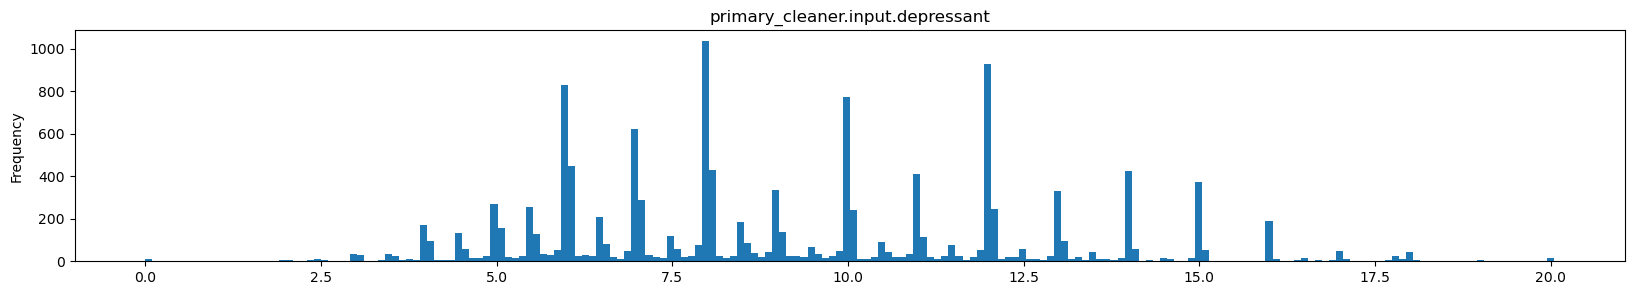

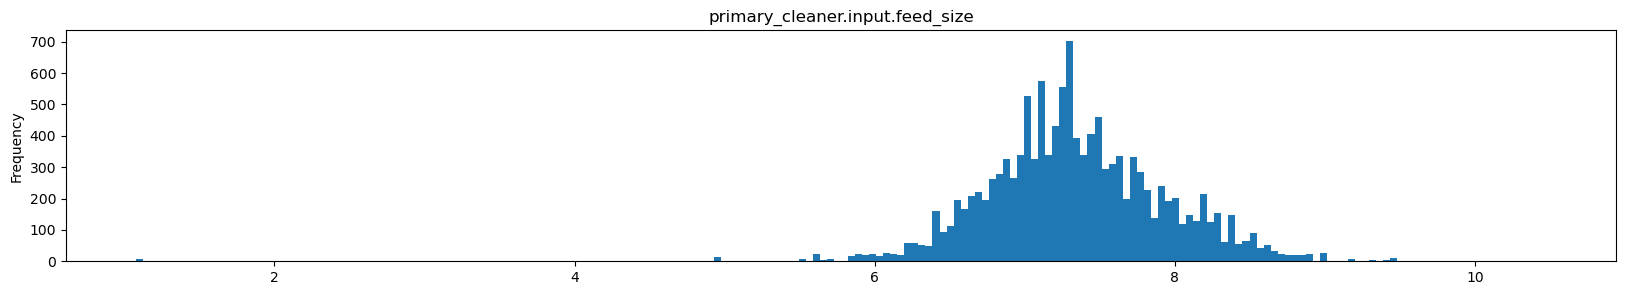

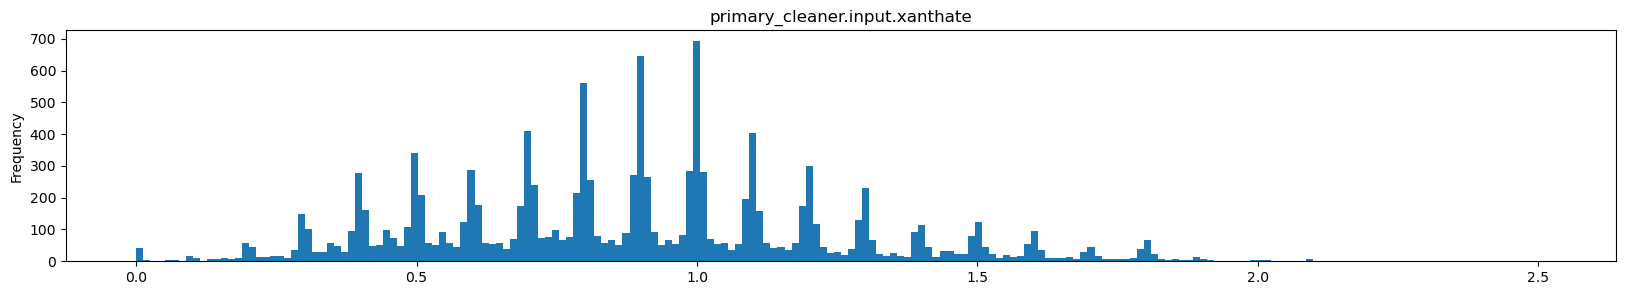

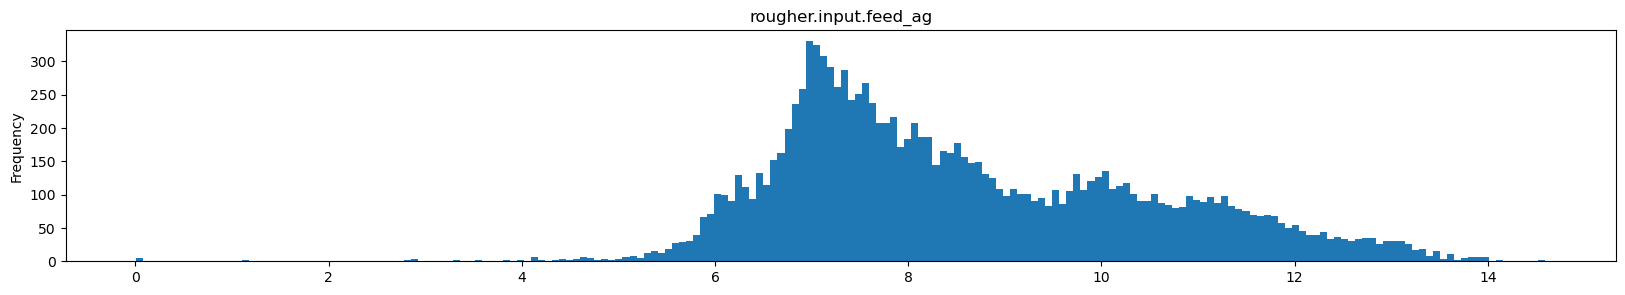

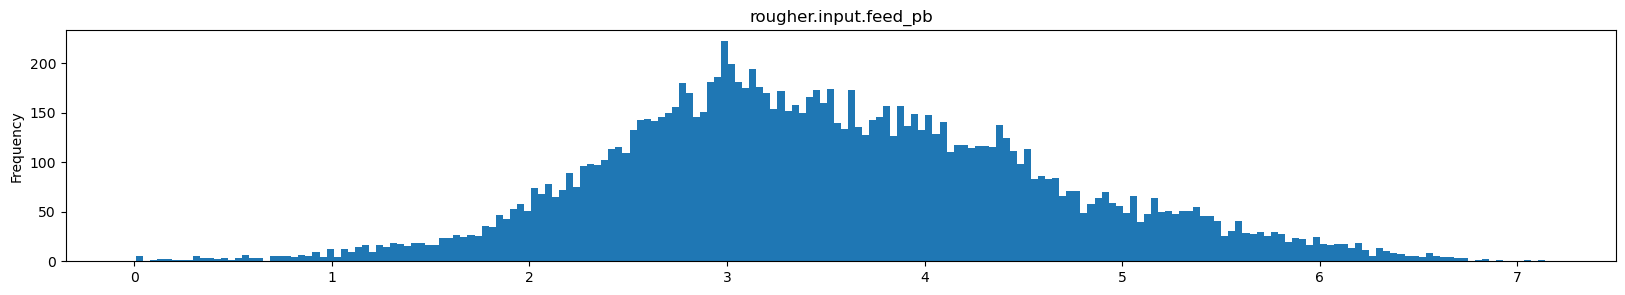

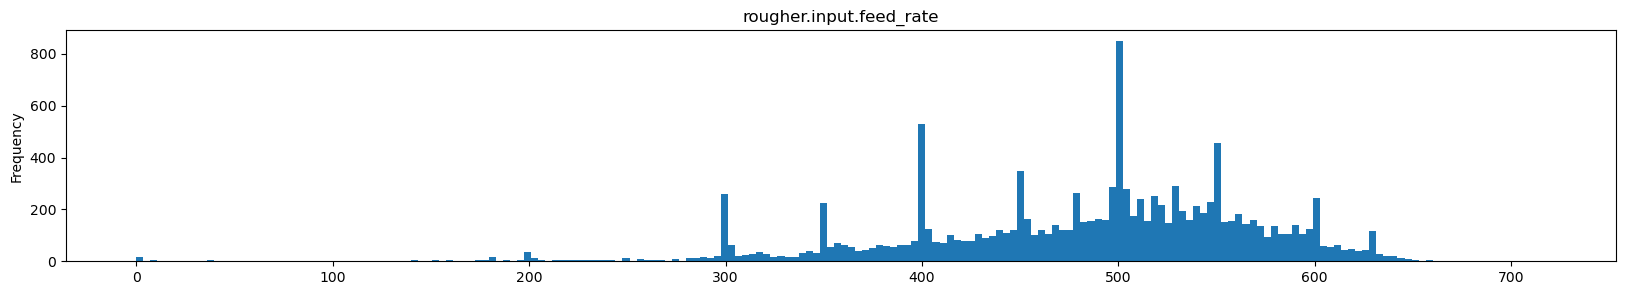

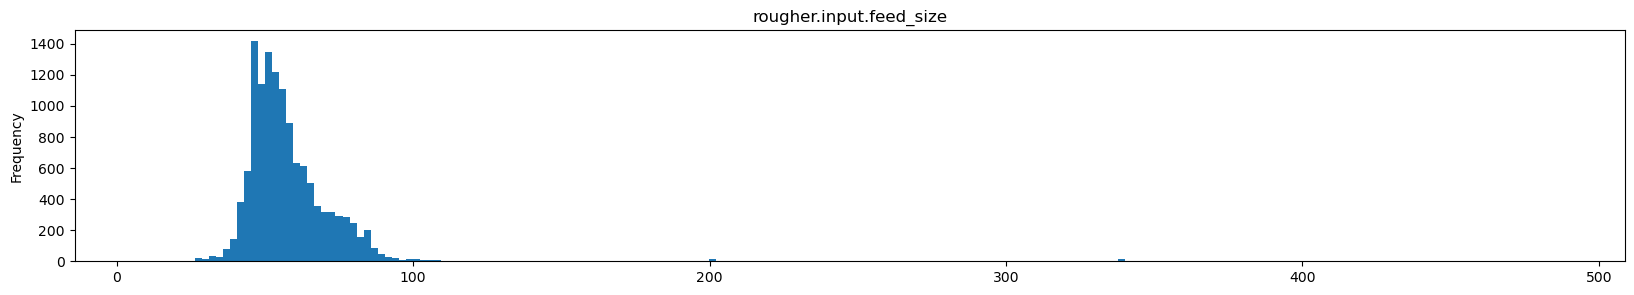

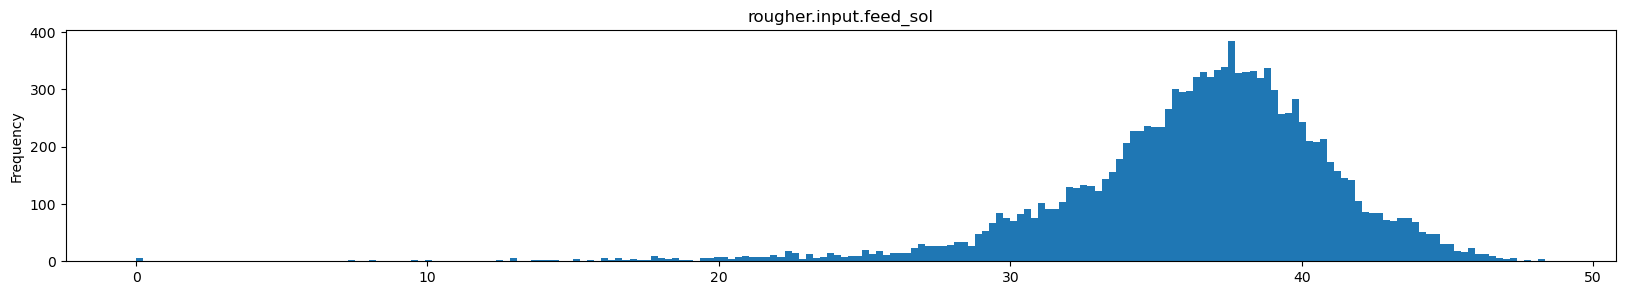

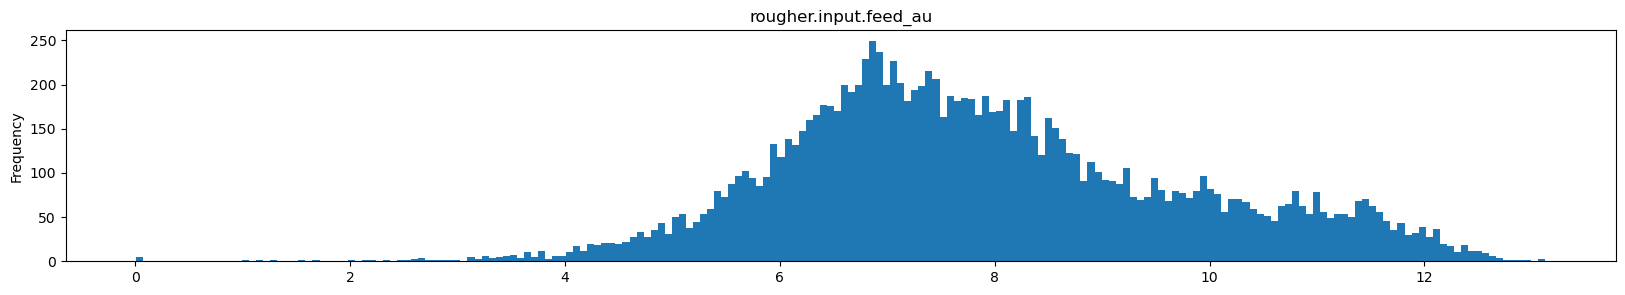

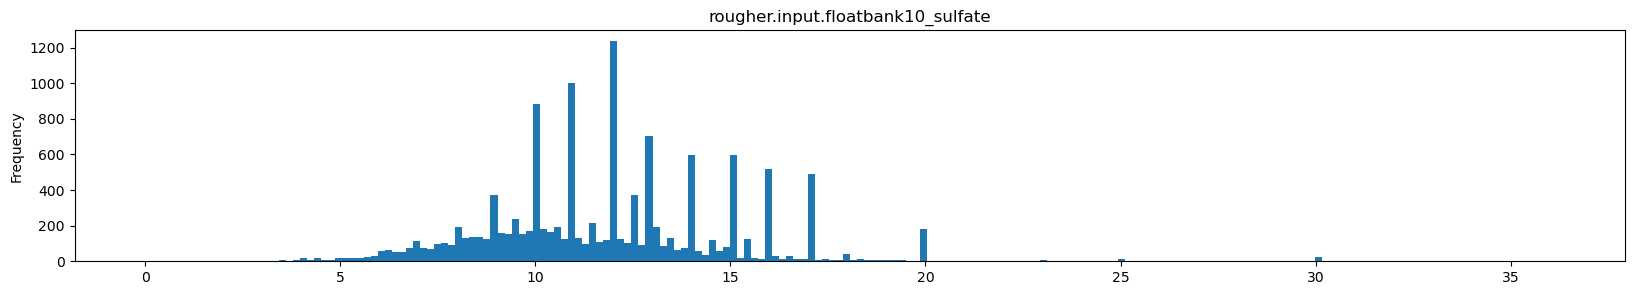

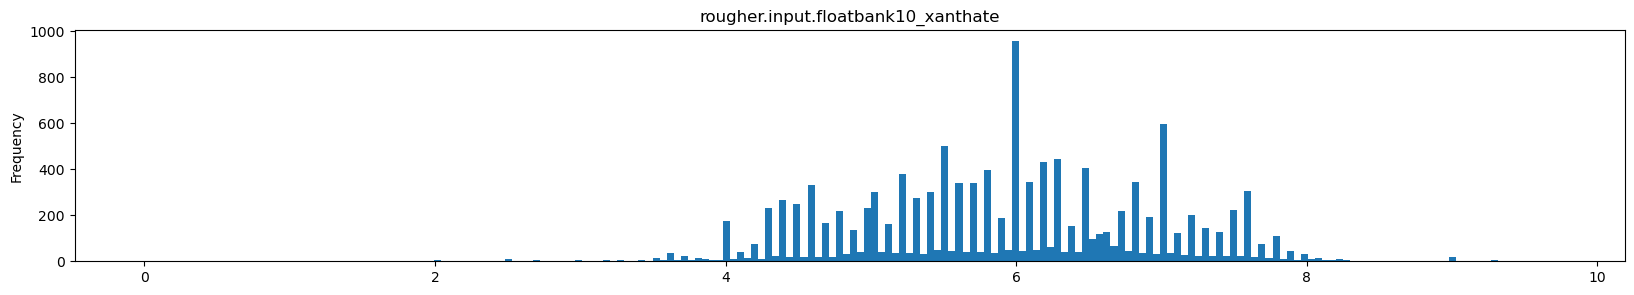

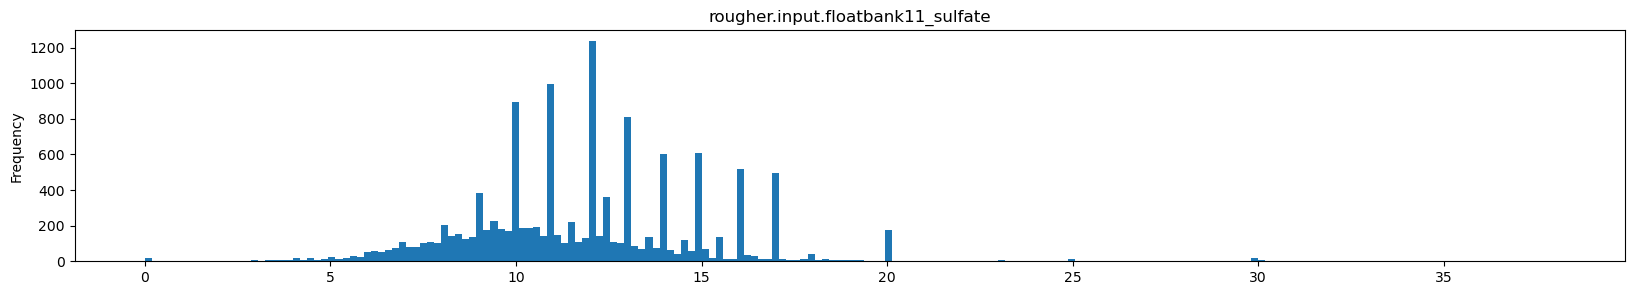

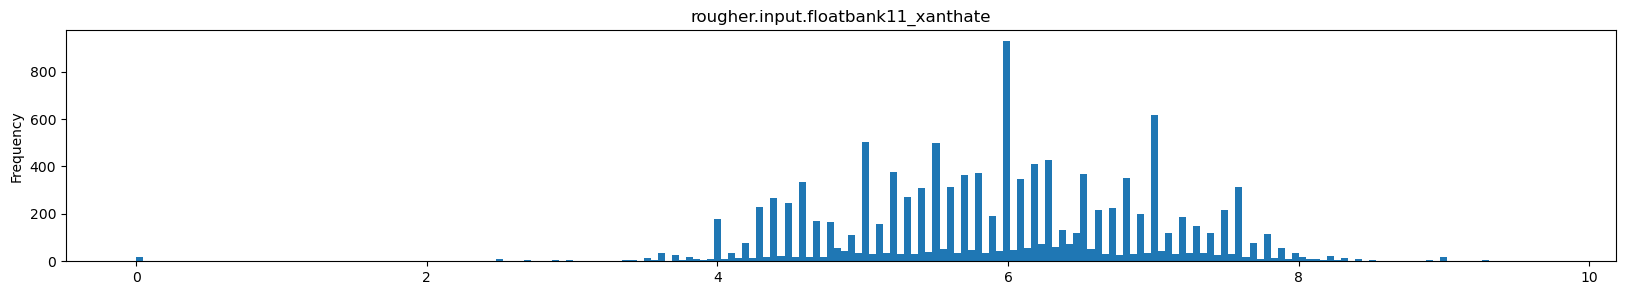

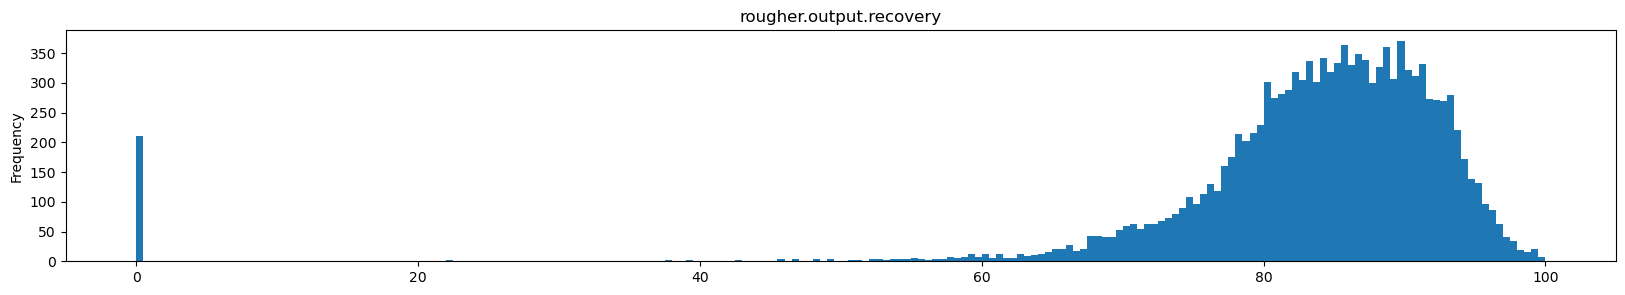

In [185]:
for i in features_list:
    train[i].plot(kind='hist', bins=200, figsize=[20, 3], title=i)
    plt.show()

Явные выбросы на значениях 0 и 100 наблюдаются в целевых признаках:  
`final.output.recovery`  
`rougher.output.recovery`  

Вероятно к выбросам на целевых признаках привели аномалии в фичах, поэтому удалим все объекты с выбросами в таргетах.

Выбросы на нулевых значениях также встречаются в признаках:  
`rougher.input.feed_ag`  
`rougher.input.feed_pb`  
`rougher.input.feed_sol`  
`rougher.input.feed_au`  
`rougher.input.feed_rate`  

In [186]:
# создадим список фичей в которых мы будем искать выбросы
outliers_list = ['final.output.recovery',
                 'rougher.output.recovery',
                 'rougher.input.feed_ag',
                 'rougher.input.feed_pb',
                 'rougher.input.feed_sol',
                 'rougher.input.feed_au',
                 'rougher.input.feed_rate']


In [187]:
# удаляем выбросы на обучающей выборке
for i in outliers_list:
    train = train.loc[(train[i] != 0) & (train[i] != 100)]
    test = test.loc[(test[i] != 0) & (test[i] != 100)]


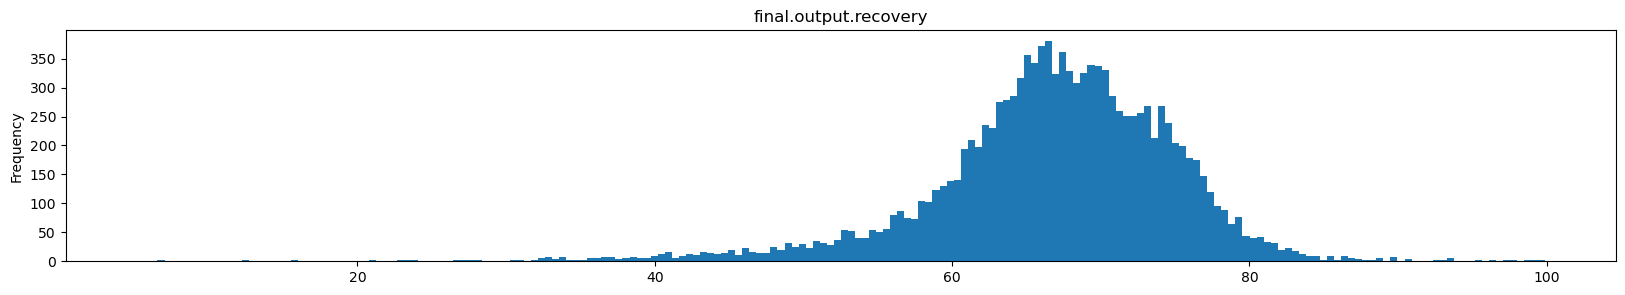

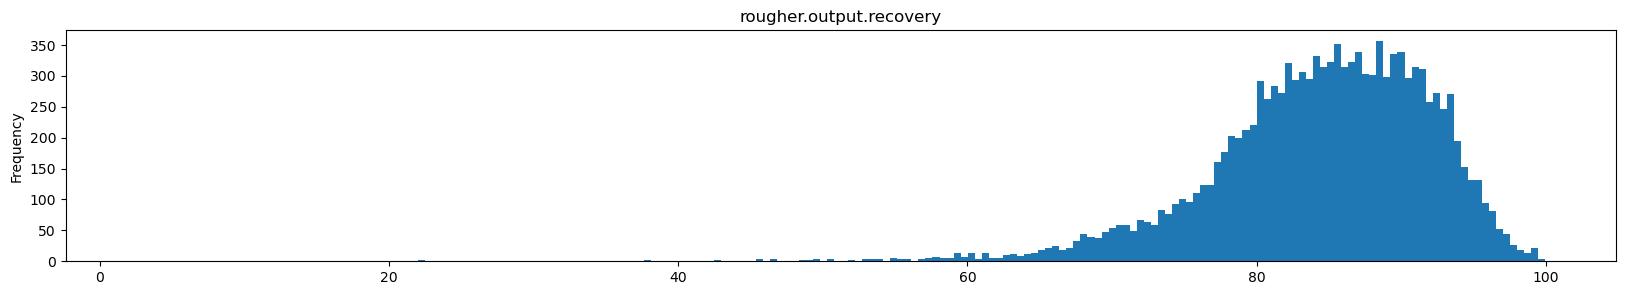

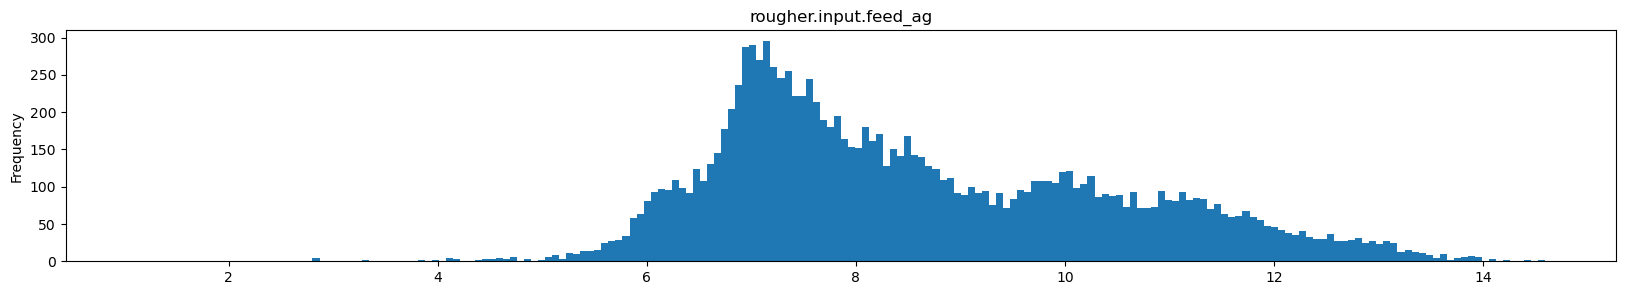

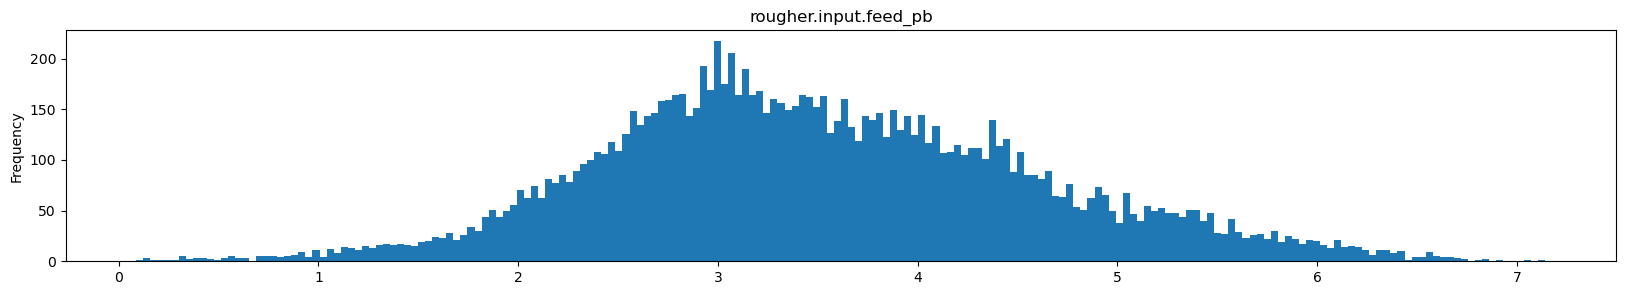

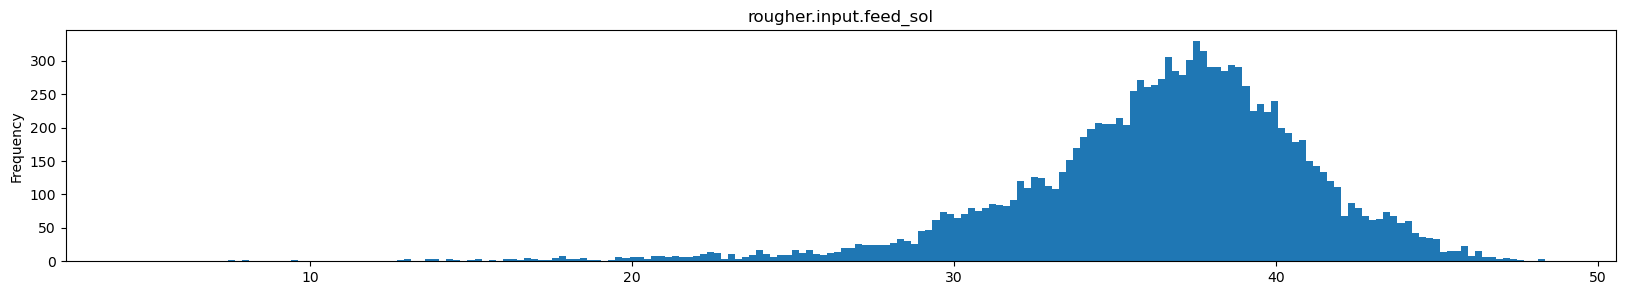

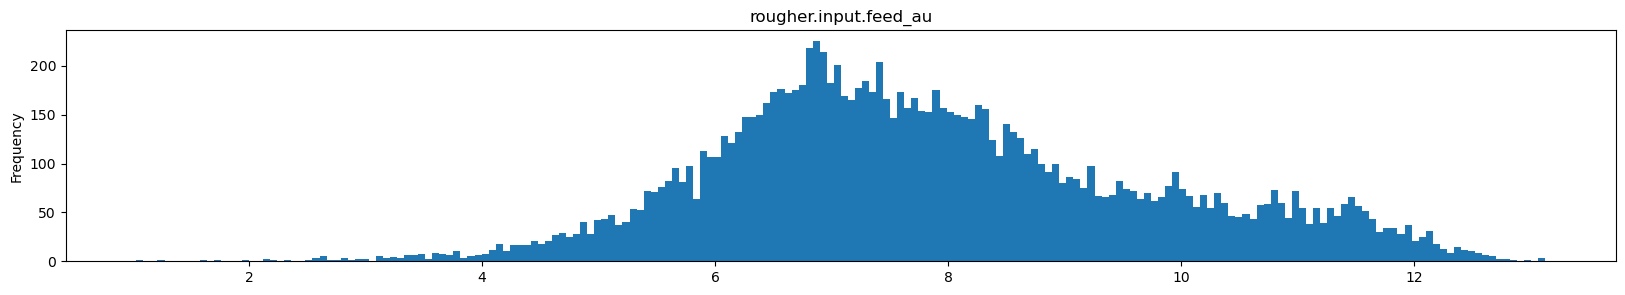

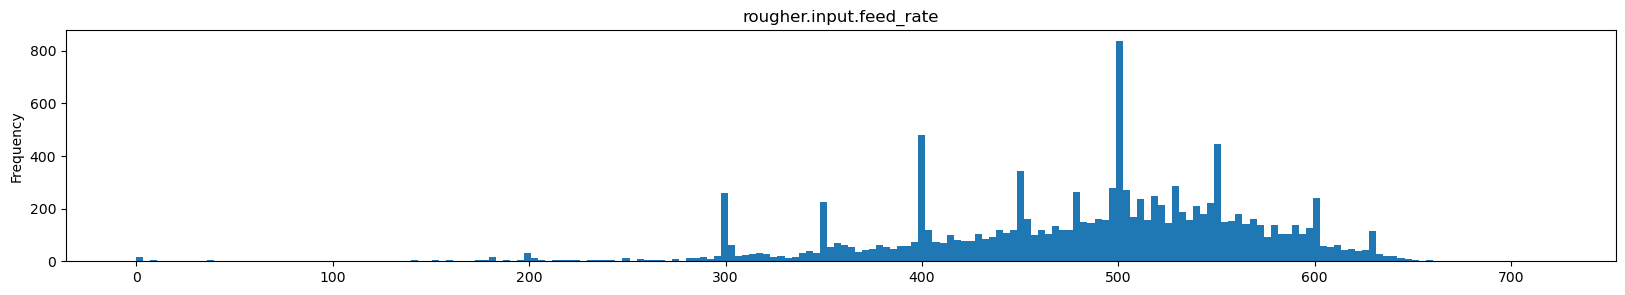

In [188]:
# проверяем результат на обучающей выборке
for i in outliers_list:
    train[i].plot(kind='hist', bins=200, figsize=[20, 3], title=i)
    plt.show()


#### 1.4.7 Разбивка выборки

In [189]:
# разделим выборку на фичи и таргет, удалим лишний столбец
feature = train.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
target = train[['rougher.output.recovery', 'final.output.recovery']]

feature_test = test.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
target_test = test[['rougher.output.recovery', 'final.output.recovery']]


#### 1.4.8 Изменение типов

In [190]:
# feature = feature.drop(['date','rougher.output.recovery','final.output.recovery'], axis=1)
feature = feature.apply(pd.to_numeric, downcast='float')
target = target.apply(pd.to_numeric, downcast='float')


1. Из обучающей выборки были удалены признаки отсутствующие в тестовой выборке
2. В тестовую выборку были добавлены соотетствующие целевые признаки
3. Построена матрица корреляции и удалены признаки с мультиколлинеарностью
4. Обработаны пропуски в данных
5. Обработаны выбросы в данных
6. Данные разбиты на выборки
7. Типы данных заменены на более лёгкие

## 2 Анализ данных

### 2.1. Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки.

В качестве источника данных считаю допустимым взять полную таблицу до разделения на выборки.

Построим гистограмы по следующим признакам

rougher.input.feed_ag  
rougher.input.feed_pb  
rougher.input.feed_au  

rougher.output.concentrate_ag  
rougher.output.concentrate_pb  
rougher.output.concentrate_au  

primary_cleaner.output.concentrate_ag  
primary_cleaner.output.concentrate_pb  
primary_cleaner.output.concentrate_au  

final.output.concentrate_au  
final.output.concentrate_ag  
final.output.concentrate_pb  

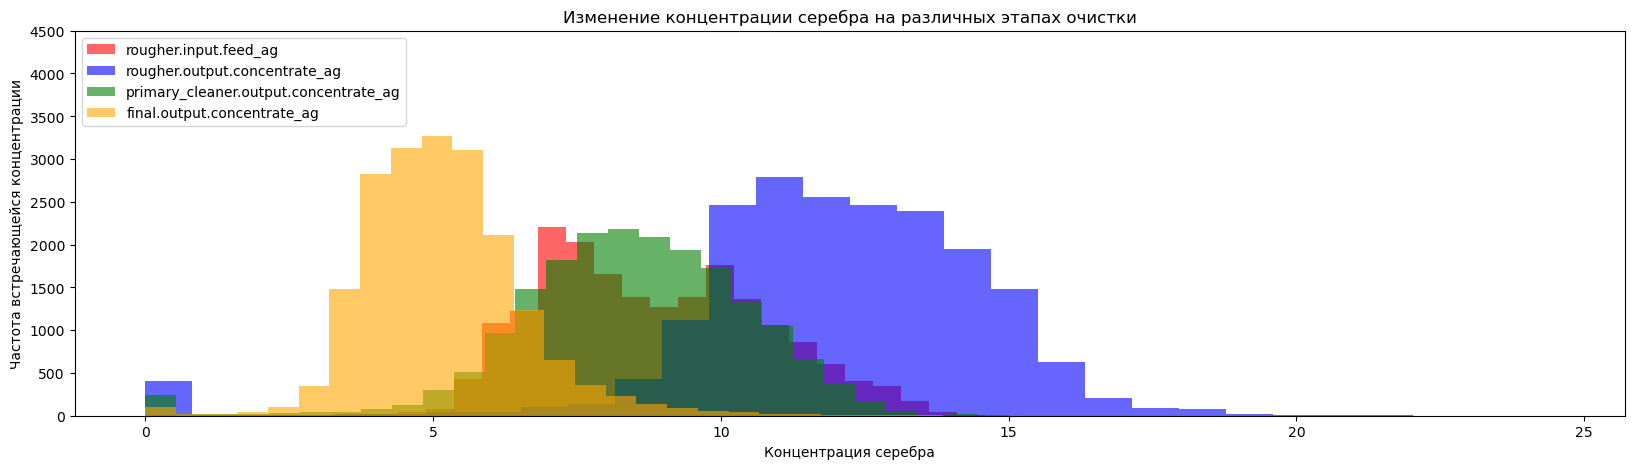

In [191]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.hist(full["rougher.input.feed_ag"], color='red',
        bins=30, alpha=0.6, label='rougher.input.feed_ag')
ax.hist(full["rougher.output.concentrate_ag"], color='blue',
        bins=30, alpha=0.6, label='rougher.output.concentrate_ag')
ax.hist(full["primary_cleaner.output.concentrate_ag"], color='green',
        bins=30, alpha=0.6, label='primary_cleaner.output.concentrate_ag')
ax.hist(full["final.output.concentrate_ag"], color='orange',
        bins=30, alpha=0.6, label='final.output.concentrate_ag')

plt.title('Изменение концентрации серебра на различных этапах очистки')
plt.xlabel('Концентрация серебра')
plt.ylabel('Частота встречающейся концентрации')
plt.ylim([0, 4500])
plt.legend(loc='upper left')
plt.show()


In [192]:
col_dict = {
    "rougher.input.feed_ag": full["rougher.input.feed_ag"].var(),
    "rougher.output.concentrate_ag": full["rougher.output.concentrate_ag"].var(),
    "primary_cleaner.output.concentrate_ag": full["primary_cleaner.output.concentrate_ag"].var(),
    "final.output.concentrate_ag": full["final.output.concentrate_ag"].var(),
}

[print(i) for i in col_dict.items()];


('rougher.input.feed_ag', 3.751378135325487)
('rougher.output.concentrate_ag', 7.474001831994568)
('primary_cleaner.output.concentrate_ag', 4.220824450791139)
('final.output.concentrate_ag', 1.8833393603220097)


Концентрация и дисперсия серебра выросла после первого этапа и снижалась на каждом последующем.

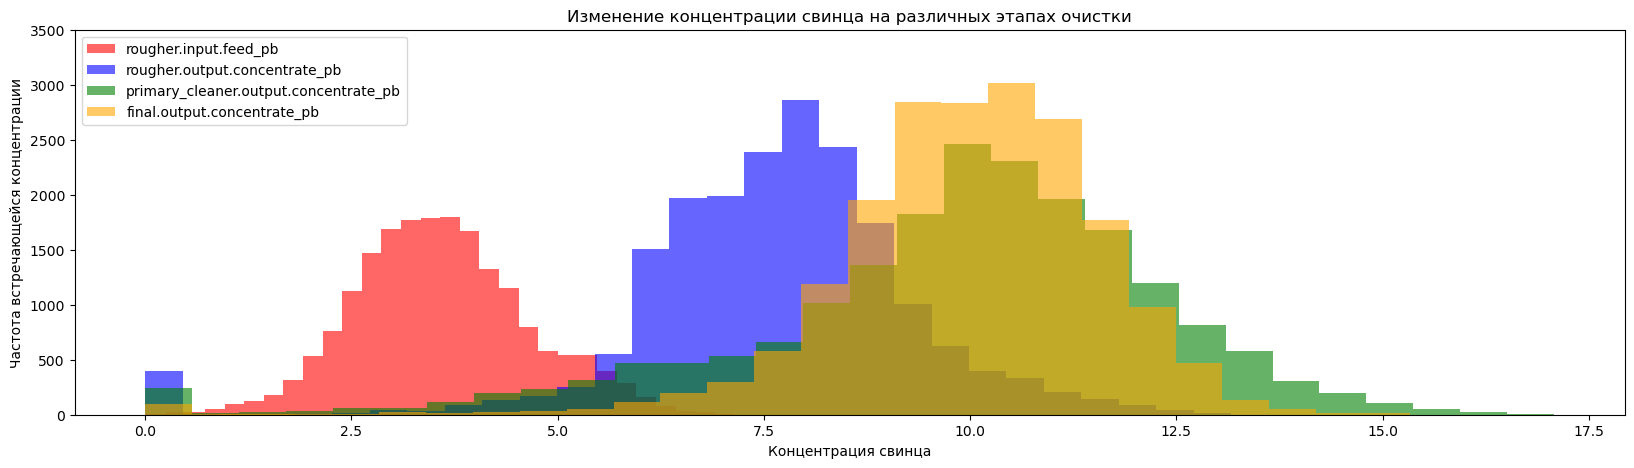

In [193]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.hist(full["rougher.input.feed_pb"], color='red',
        bins=30, alpha=0.6, label='rougher.input.feed_pb')
ax.hist(full["rougher.output.concentrate_pb"], color='blue',
        bins=30, alpha=0.6, label='rougher.output.concentrate_pb')
ax.hist(full["primary_cleaner.output.concentrate_pb"], color='green',
        bins=30, alpha=0.6, label='primary_cleaner.output.concentrate_pb')
ax.hist(full["final.output.concentrate_pb"], color='orange',
        bins=30, alpha=0.6, label='final.output.concentrate_pb')

plt.title('Изменение концентрации свинца на различных этапах очистки')
plt.xlabel('Концентрация свинца')
plt.ylabel('Частота встречающейся концентрации')
plt.ylim([0, 3500])
plt.legend(loc='upper left')
plt.show()


In [194]:
col_dict = {
    "rougher.input.feed_pb": full["rougher.input.feed_pb"].var(),
    "rougher.output.concentrate_pb": full["rougher.output.concentrate_pb"].var(),
    "primary_cleaner.output.concentrate_pb": full["primary_cleaner.output.concentrate_pb"].var(),
    "final.output.concentrate_pb": full["final.output.concentrate_pb"].var(),
}

[print(i) for i in col_dict.items()];

('rougher.input.feed_pb', 1.1014215122060946)
('rougher.output.concentrate_pb', 3.228333927318858)
('primary_cleaner.output.concentrate_pb', 6.5374464481871275)
('final.output.concentrate_pb', 2.7863605774866946)


Концентрация и дисперсия свинца повышается на всех этапах. Концентрация незначительно повышается на последнем этапе, но значительно снижается дисперсия.

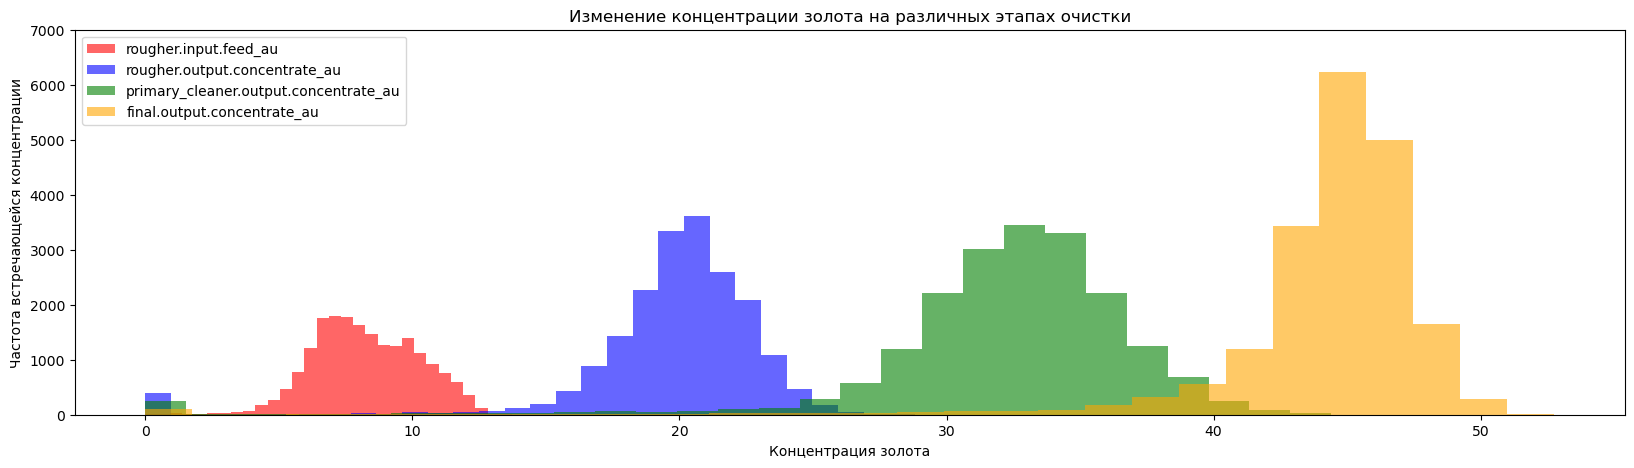

In [195]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.hist(full["rougher.input.feed_au"], color='red',
        bins=30, alpha=0.6, label='rougher.input.feed_au')
ax.hist(full["rougher.output.concentrate_au"], color='blue',
        bins=30, alpha=0.6, label='rougher.output.concentrate_au')
ax.hist(full["primary_cleaner.output.concentrate_au"], color='green',
        bins=30, alpha=0.6, label='primary_cleaner.output.concentrate_au')
ax.hist(full["final.output.concentrate_au"], color='orange',
        bins=30, alpha=0.6, label='final.output.concentrate_au')

plt.title('Изменение концентрации золота на различных этапах очистки')
plt.xlabel('Концентрация золота')
plt.ylabel('Частота встречающейся концентрации')
plt.ylim([0, 7000])
plt.legend(loc='upper left')
plt.show()


In [196]:
col_dict = {
    "rougher.input.feed_au": full["rougher.input.feed_au"].var(),
    "rougher.output.concentrate_au": full["rougher.output.concentrate_au"].var(),
    "primary_cleaner.output.concentrate_au": full["primary_cleaner.output.concentrate_au"].var(),
    "final.output.concentrate_au": full["final.output.concentrate_au"].var(),
}

[print(i) for i in col_dict.items()];

('rougher.input.feed_au', 3.8223857499716027)
('rougher.output.concentrate_au', 14.089509281090141)
('primary_cleaner.output.concentrate_au', 31.67000494779096)
('final.output.concentrate_au', 26.314682783896245)


Концентрация золота повышается после каждого этапа производства, чего и следовало ожидать. Дисперсия повышается на первом и втором этапе и снижается на третьем.

Ранее на этапе предобработки были выявлены аномалии, а именно, большое количество нулевых значений. Мы уже обработали выбросы на обучающей выборке, на этом этапе оценивали концентрации веществ на полной выборке, чтобы просмотреть данные без искажений.

### 2.2.  Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках.

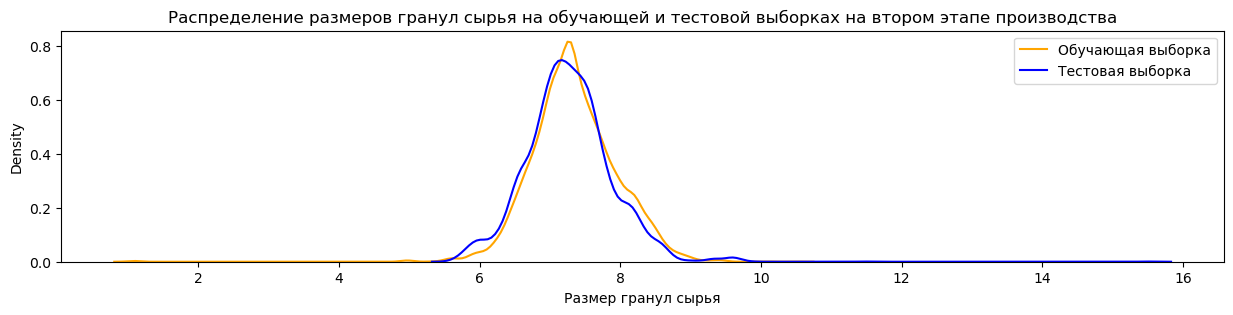

In [197]:
fig, ax = plt.subplots(figsize=(15, 3))

sns.kdeplot(train["primary_cleaner.input.feed_size"],
            color='orange', label='Обучающая выборка')
sns.kdeplot(test["primary_cleaner.input.feed_size"],
            color='blue', label='Тестовая выборка')

plt.title('Распределение размеров гранул сырья на обучающей и тестовой выборках на втором этапе производства')
plt.legend(loc='upper right')
plt.xlabel('Размер гранул сырья')
plt.show()


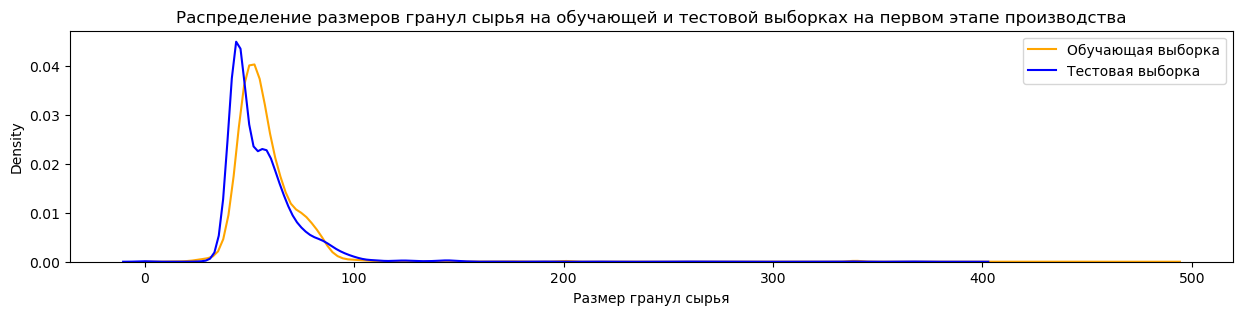

In [198]:
fig, ax = plt.subplots(figsize=(15, 3))

sns.kdeplot(train["rougher.input.feed_size"],
            color='orange', label='Обучающая выборка')
sns.kdeplot(test["rougher.input.feed_size"],
            color='blue', label='Тестовая выборка')

plt.title('Распределение размеров гранул сырья на обучающей и тестовой выборках на первом этапе производства')
plt.legend(loc='upper right')
plt.xlabel('Размер гранул сырья')
plt.show()


Распределение гранул сырья на обеих выборках на двух этапах производства схожи, следовательно модель будет работать корректно.

### 2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

In [199]:
[print(i) for i in full.columns if 'concentrate_' in i];

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au


У нас есть данные по концентрации 4х веществ (ag, pb, sol, au).

In [200]:
list_of_concentrates = [
    ['rougher.input.feed_ag',
     'rougher.input.feed_pb',
     'rougher.input.feed_sol',
     'rougher.input.feed_au'],
    ['rougher.output.concentrate_ag',
     'rougher.output.concentrate_pb',
     'rougher.output.concentrate_sol',
     'rougher.output.concentrate_au'],
    ['final.output.concentrate_ag',
     'final.output.concentrate_pb',
     'final.output.concentrate_sol',
     'final.output.concentrate_au']
]


In [201]:
full_1 = full.copy()
full_1['temp_rougher_input'] = full_1[list_of_concentrates[0]].sum(axis=1)
full_1['temp_rougher_output'] = full_1[list_of_concentrates[1]].sum(axis=1)
full_1['temp_final_conc'] = full_1[list_of_concentrates[2]].sum(axis=1)


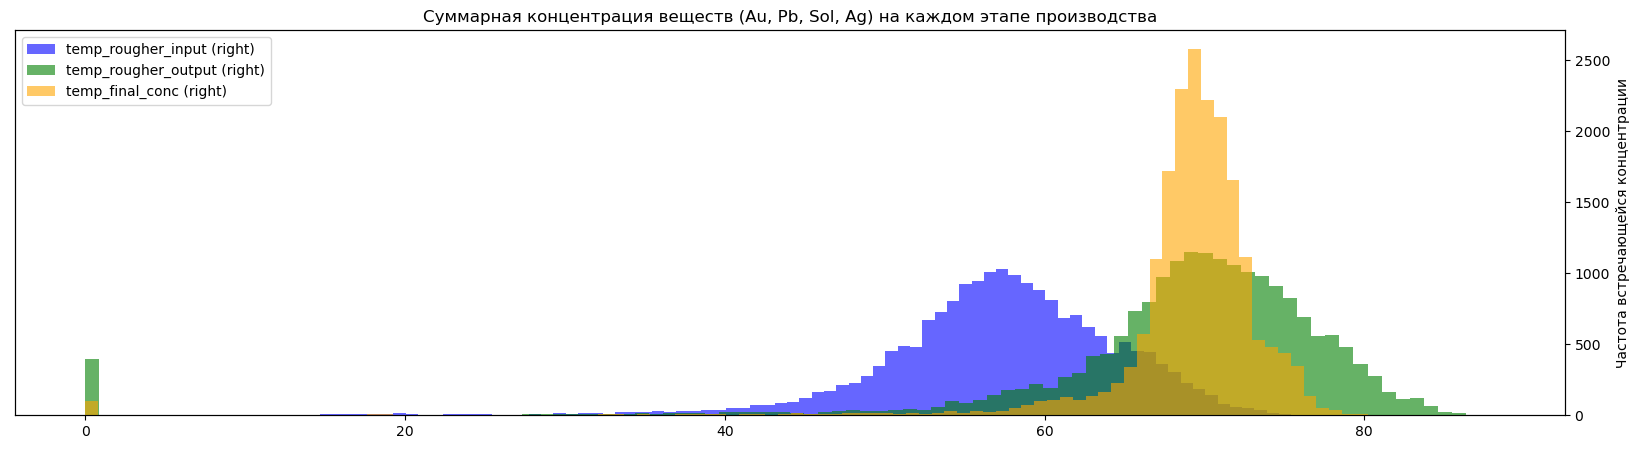

In [202]:
full_1['temp_rougher_input'].plot(kind='hist', color='blue', bins=100, alpha=0.6, figsize=[20, 5], secondary_y=True)
full_1['temp_rougher_output'].plot(kind='hist', color='green', bins=100, alpha=0.6, figsize=[20, 5], secondary_y=True)
full_1['temp_final_conc'].plot(kind='hist', color='orange', bins=100, alpha=0.6, figsize=[20, 5], secondary_y=True)

plt.title("Суммарная концентрация веществ (Au, Pb, Sol, Ag) на каждом этапе производства")
plt.xlabel('Суммарная концентрация металлов')
plt.ylabel('Частота встречающейся концентрации')
plt.legend(loc='upper left')

plt.legend(loc='upper left')
plt.show()

In [203]:
col_dict = {
    "temp_rougher_input": full_1["temp_rougher_input"].var(),
    "temp_rougher_output": full_1["temp_rougher_output"].var(),
    "temp_final_conc": full_1["temp_final_conc"].var()
}

[print(i) for i in col_dict.items()];

('temp_rougher_input', 59.48677183295303)
('temp_rougher_output', 157.25212034170366)
('temp_final_conc', 55.68093495080305)


На гистограме выведена суммарная концентрация всех примесей на каждом этапе производства. На графике видно, что концентрация веществ и дисперсия увеличивается после первого этапа, после второго этапа концентрация увеличивается незначительно, дисперсия значительно уменьшается.

In [204]:
del full_1

1. Концентрация серебра снижается на каждом этапе производства кроме первого, концентрация золота повышается на каждом этапе, концентрация свинца повышается после первого и второго этапа и не почти не изменяется после третьего.  
2. Распределения размеров гранул сырья на обучающей и тестовой выборках отличаются не сильно. Различие не повлияет на качество модели.
3. Суммарная концентрация всех веществ (Au, Pb, Ag, Sol) на протяжении цикла производства увеличивается, в особенности после первого этапа.

## 3 Модель

### 3.1. Напишем функцию для вычисления итоговой метрики - sMAPE

${\Large sMAPE = \dfrac{1}{N}\displaystyle\sum_{i=1}^N \dfrac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|)/2}\times 100\%}$

${\large y_i}$  -  Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.  

${\large \hat {y_i}}$  -  Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.  

${\large N}$  -  Количество объектов в выборке.  

${\large \displaystyle \sum_{i=1}^{N}}$  -  Суммирование по всем объектам выборки (i меняется от 1 до N).  

$\large {Итоговое\space sMAPE = 25\% \cdot sMAPE(rougher) + 75\% \cdot sMAPE(final)}$

,где  
эффективность обогащения чернового концентрата `rougher.output.recovery`;  
эффективность обогащения финального концентрата `final.output.recovery`

In [205]:
# функция для рассчёта sMAPE
def smape(true, test):
    return 100*sum([abs(y - y_hat) / ((abs(y) + abs(y_hat)) / 2)
                    if not y == y_hat == 0 else 0 for y, y_hat in zip(true, test)]) / len(true)


In [206]:
# функция для рассчёта итогового sMAPE
def final_smape(true_target, pred_target):
    test_rougher = [i[0] for i in pred_target]
    test_final = [i[1] for i in pred_target]
    true_rougher = true_target['rougher.output.recovery']
    true_final = true_target['final.output.recovery']
    return (0.25*smape(true_rougher, test_rougher) + 0.75*smape(true_final, test_final))


### 3.2 Обучение моделей

Необходимо спрогнозировать сразу две величины:  
эффективность обогащения чернового концентрата `rougher.output.recovery`;  
эффективность обогащения финального концентрата `final.output.recovery`.  

In [207]:
# выбираем несколько моделей и добавляем в список
regressors = [LinearRegression(),
              DecisionTreeRegressor(random_state=10),
              RandomForestRegressor(random_state=10),
              ElasticNet(random_state=10)]

# декларируем словарь в котором будем хранить лучшие модели
best_models = {}

# проходим циклом по списку моделей
for regressor in regressors:

    # используем пайплайн чтобы масштабировать признаки в грид-сёрче
    pipeline = Pipeline([('scale', StandardScaler()), ('clf', regressor)])

    # определяем гиперпараметры для перебора
    if isinstance(pipeline['clf'], DecisionTreeRegressor):
        param_grid = {'clf__max_depth': [i for i in range(1, 30)]}
    elif isinstance(pipeline['clf'], RandomForestRegressor):
        param_grid = {'clf__n_estimators': [i for i in range(1, 15, 1)], 'clf__max_depth': [
            i for i in range(1, 15, 1)]}
    elif isinstance(pipeline['clf'], ElasticNet):
        param_grid = {'clf__alpha': [
            1/i**2 for i in range(1, 10, 1)], 'clf__l1_ratio': [1/(i/10)**2 for i in range(10, 20, 1)]}
    else:
        # т.к. линейная регрессия не требует перебора параметра мы можем вывести нужные метрики уже на этом этапе
        target_predicted = cross_val_predict(pipeline, feature, target, cv=5)
        print(f'For {pipeline} final sMAPE = {final_smape(target, target_predicted)}')
        pipeline.fit(feature, target)
        predicted = pipeline.predict(feature_test)
        continue

    # используем гридсёрч для опимизации моделей, в качестве метрики скоринга минимизируем final_smape
    grid_search = GridSearchCV(pipeline,
                               param_grid,
                               scoring=make_scorer(
                                   final_smape, 
                                   greater_is_better=False
                               ),
                               cv=8,
                               n_jobs=-1)

    # выбираем лучшую модель в цикле
    grid_search.fit(feature, target)
    regressor_best = grid_search.best_estimator_

    target_predicted = regressor_best.predict(feature)
    res_smape = final_smape(target, target_predicted)

    # выводим лучший результат
    print(f'For {regressor_best} final sMAPE = {res_smape}')
    best_models[res_smape] = regressor_best


For Pipeline(steps=[('scale', StandardScaler()), ('clf', LinearRegression())]) final sMAPE = 9.38653967793768
For Pipeline(steps=[('scale', StandardScaler()),
                ('clf', DecisionTreeRegressor(max_depth=4, random_state=10))]) final sMAPE = 6.716808429199433
For Pipeline(steps=[('scale', StandardScaler()),
                ('clf',
                 RandomForestRegressor(max_depth=4, n_estimators=13,
                                       random_state=10))]) final sMAPE = 6.455722288822185
For Pipeline(steps=[('scale', StandardScaler()),
                ('clf',
                 ElasticNet(l1_ratio=0.2770083102493075, random_state=10))]) final sMAPE = 7.101420449334725


Лучшая модель на кросс-валидации `RandomForestRegressor` с параметром `max_depth=4`,`n_estimators=13` показала результат `итогового sMAPE = 6.45%`

In [208]:
m = 100
for i in best_models.keys():
    if i < m:
        m = i
best_model = best_models[m]


In [209]:
predicted = best_model.predict(feature_test)
print(f'Модель {best_model[1]} на тестовой выборке показала результат итогового sMAPE = {round(final_smape(target_test, predicted),2)}%')


Модель RandomForestRegressor(max_depth=4, n_estimators=13, random_state=10) на тестовой выборке показала результат итогового sMAPE = 8.58%


1. Были написаны формулы для рассчёта sMAPE и итогового sMAPE
2. Было обучено несколько моделей LinearRegression, DecisionTreeRegressor, RandomForestRegressor, ElasticNet и перебраны гиперпараметры для них с помощью gridSearchCV
3. Лучшая модель прошла тест на тестовой выборке с результатом итогового sMAPE = 8.58%
4. Лучшая модель RandomForestRegressor(max_depth=4, n_estimators=13)

## Общий вывод

На первом этапе были погдготовлены данные проекта, а именно:  
   1. Из обучающей выборки были удалены признаки отсутствующие в тестовой выборке  
   2. В тестовую выборку были добавлены соотетствующие целевые признаки  
   3. Построена матрица корреляции и удалены признаки с мультиколлинеарностью  
   4. Данные предобработаны для обучения модели

На втором этапе был проведён анализ данных по заранее определённым критериям, было выявлено, что:  
   1. Концентрация серебра снижается на каждом этапе производства, концентрация золота повышается, концентрация свинца повышается после первого этапа и не изменяется после второго.    
   2. Распределения размеров гранул сырья на обучающей и тестовой выборках отличаются не сильно. Различие не повлияет на качество модели.  
   3. Суммарная концентрация всех веществ на протяжении цикла увеличивается.  

На третьем этапе:  
   1. Были написаны формулы для рассчёта sMAPE и итогового sMAPE  
   2. Было обучено несколько моделей LinearRegression, DecisionTreeRegressor, RandomForestRegressor, ElasticNet и перебраны гиперпараметры для них с помощью gridSearchCV  
   3. Лучшая модель прошла тест на тестовой выборке с результатом итогового sMAPE = 8.58%  
   4. Лучшая модель RandomForestRegressor(max_depth=4, n_estimators=13)  